# ASMR 팀 모델 설명서

#  Abstract (분석 절차)
### 1. 새로운 train 데이터 생성
 EDA를 진행해본 결과 주어진 train과 test의 성질이 상당히 다르다고 생각하여, test와 비슷한 new_train을 생성
### 2. EDA 및 전처리
 EDA를 기반으로 데이터 전처리를 진행
### 3. 1차 분석 및 전처리
 생성한 데이터로 1차 회귀분석OLS)을 실시하였으며 이를 기반으로 다시 데이터 전처리를 진행 
### 4. 자기상관성을 제거하기 위한 모델 수정
 수정된 데이터로 2차 회귀 분석(OLS)을 실행하였으며, 모델의 문제점인 자기상관성을 해결하기 위해서 데이터를 수정
### 5. 최종 모델링
 모델의 문제점을 해결하여 최종 모델링(GLS)을 진행
### 6. 예측
 test 데이터를 train과 동일한 형태로 생성한 뒤 최종 예측을 진행

In [3]:
# colab에서 google drive mount
from google.colab import drive
drive.mount('/content/drive')

# library
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image
from sklearn.linear_model import LinearRegression

# r 코드를 사용하기 위한 라이브러리
from rpy2.robjects import r  
%load_ext rpy2.ipython

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# 0. 사용한 모델 설명
## 회귀분석

회귀 모형은 다음과 같은 수식을 기반으로 한다. 

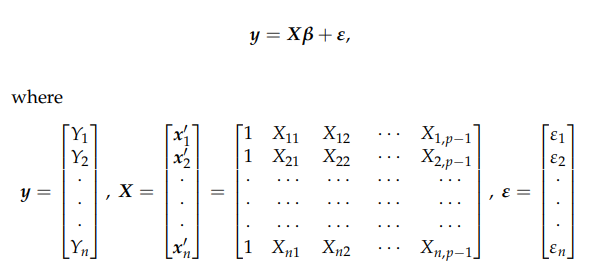

In [4]:
Image("/content/drive/MyDrive/dacon_NH/reg_img_1.PNG")

여기서 X는 독립변수(설명변수), y는 종속변수가 된다. $\beta$는 각 변수에 곱해지는 회귀계수(가중치), $\epsilon$은 오차이다. 
회귀 분석은 $\beta$(회귀계수)를 잘 추정하여 실제 y값과 추정된 y값의 잔차를 최소화하는 것을 목표로 한다. 

이때, 잔차의 제곱값을 최소화하는 값으로 회귀 계수를 추정하며 이를 LSE(Least Square Estimator)라고 한다. LSE는 다음 수식과 같다 

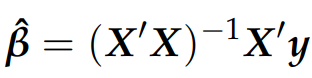

In [5]:
Image("/content/drive/MyDrive/dacon_NH/reg_img_3.PNG")

### 회귀분석에서 LSE(Least Square Estimator)는 Gauss-Markov Assumption의 만족여부에 따라 BLUE(Best linear Unbiased Estimator) 또는 BUE(Best Unbiased Estimator) 라는 좋은 추정치가 될 수 있다.
### Gauss-Markov Assumption은 다음과 같다.

- A1. Full rank & Invertibility
- A2. y=X$\beta$ +$\epsilon$ and E($\epsilon$)=0
- A3. X & $\epsilon$ :independent
- A4. No correlation & No heteroskedasticity
- A5. Gaussian Normality of the $\epsilon$'s distribution

#### A1 ~ A4 만족 : LSE는 BLUE(Best Linear Unbiased Estimator)가 된다.

#### A1 ~ A5 만족 : LSE=MLE가 되고, 이는 BUE(Best Unbiased Estimator)가 된다. 

## GLS(Generalized Least Squares)
GLS 방법은 회귀분석이 A4의 등분산성(homoskedasticity)을 만족하지 못했을 경우 가중치를 이용하여 미세조정 한 뒤 더 잘맞는 모델을 만들 수 있게 해준다.

# 1. 데이터 불러오기 및 새로운 train 생성

In [6]:
train=pd.read_csv("/content/drive/MyDrive/dacon_NH/stk_hld_train.csv")
test=pd.read_csv("/content/drive/MyDrive/dacon_NH/stk_hld_test.csv")


train[:5]

,act_id,iem_cd,byn_dt,hold_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,20180726,11
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005930,20180131,80
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005070,20180517,5
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A003520,20201112,22
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A002310,20180905,324


train의 hold_d와 test의 hist_d의 기술 통계량을 살펴본다. 

In [7]:
a=pd.DataFrame(train.describe()['hold_d'])
a['test_hist_d']=test.describe()['hist_d']
a.rename(columns={"hold_d":"train_hold_d"},inplace=True)
a

,train_hold_d,test_hist_d
count,681472.000000,70596.000000
mean,19.592600,113.240849
std,52.651629,162.830480
min,1.000000,1.000000
25%,1.000000,14.000000
50%,4.000000,56.000000
75%,14.000000,131.000000
max,1184.000000,1227.000000


 예측 대상이 되는 test 의 hold_d가 hist_d보다 크다는 것을  고려하면 train에서의 hold_d와 test 에서의 hold_d의 분포가 상당히 다를 것으로 예상이 된다.

## 본격적인 분석을 하기 앞서 크게 2가지가 문제가 된다.
### 1. hist_d 변수가 train에 존재하지 않는다.
(hold_d = hist_d + $\alpha$ 이므로 hist_d와 hold_d의 연관성이 클 것으로 예상된다)
### 2. train과 test가 성질이 다르다. 
target의 분포, 주식이 시점에 따라 영향을 되게 크게 받는다는 점 등을 고려했을 때 train과 test의 성질이 다르다고 판단하였다.

## 이러한 문제를 해결하기 위해서 다음과 같은 방법으로 새로운 train을 생성하였다.
- 2020년 1월을 기준으로 그전에 매수한 뒤 그 이후 매도한 관측치만 추출하였다.
- 2018년에 매수해서 2019년에 매도한 관측치도 추출하였다. 
- hist_d라는 변수생성 & test의 성질을 고려하여 위의 두가지 데이터를 결합하여 new_train을 생성하였다.

### 정확히 hist_d를 생성하기 위해 다음과 같이 매년 휴일을 조사하였다.

#### 2019 주식 시장 휴일 
- 1월: 1, 5,6,12,13,19,20,26,27     =>max=31
- 2월: 4,5,6 ,2,3,9,10,16,17,23,24  =>max=28
- 3월: 1, 2,3,9,10,16,17,23,24,30,31=>max=31
- 4월: 6,7,13,14,20,21,27,28        =>max=30  
- 5월: 1,6, 4,5,11,12,18,19,25,26   =>max=31
- 6월: 6, 1,2,8,9,15,16,22,23,29,30 =>max=30 
- 7월: 6,7,13,14,20,21,27,28        =>max=31
- 8월: 15, 3,4,10,11,17,18,24,25,31 =>max=31
- 9월: 12,13, 1,7,8,14,15,21,22,28,29=>max=30
- 10월: 3,9 ,5,6,12,13,19,20,26,27    =>max=31
- 11월: 2,3,9,10,16,17,23,24,30       =>max=30
- 12월: 25,31, 1,7,8,14,15,21,22,28,29=>max=31

#### 2018 주식 시장 휴일
- 1월: 1 / 6,7,13,14,20,21,27,28  -> max :31
- 2월: 15,16 / 3,4,10,11,17,18,24,25 ->max:28
- 3월: 1 / 3,4,10,11,17,18,24,25,31 -> max:31
- 4월: 1,7,8,14,15,21,22,28,29 -> max:30
- 5월: 1,7,22 /5,6,12,13,19,20,26,27 ->max:31
- 6월: 6,13 / 2,3,9,10,16,17,23,24,30 ->max:30
- 7월: 1,7,8,14,15,21,22,28,29 -> max:31
- 8월: 15 / 4,5,11,12,18,19,25,26 -> max:31
- 9월: 24,25,26 / 1,2,8,9,15,16,22,23,29,30 -> max:30
- 10월: 3,9 / 6,7,13,14,20,21,27,28 ->max:31
- 11월: 3,4,10,11,17,18,24,25 -> max:30
- 12월: 25,31 / 1,2,8,9,15,16,22,23,29,30 -> max:31

#### 2017 주식 시장 휴일
- 1월: 27,28,29,30 / 1,7,8,14,15,21,22
- 2월: 4,5,11,12,18,19,25,26
- 3월: 1 / 4,5,11,12,18,19,25,26
- 4월: 1,2,8,9,15,16,22,23,29,30
- 5월: 1,3,5,9 / 6,7,13,14,20,21,27,28
- 6월: 6 /3,4,10,11,17,18,24,25
- 7월: 1,2,8,9,15,16,22,23,29,30
- 8월: 15 /5,6,12,13,19,20,26,27
- 9월: 2,3,9,10,16,17,23,24,30
- 10월: 2,3,4,5,6,9 / 1,7,8,14,15,21,22,28,29
- 11월: 4,5,11,12,18,19,25,26
- 12월: 25,29/2,3,9,10,16,17,23,24,30,31

In [8]:
# 날짜 정보 분리
train_all=train.copy()

train_all['year']=train_all.byn_dt//10000
train_all['month']=(train_all['byn_dt']%10000)//100
train_all['date']=train_all['byn_dt']%100

### 19년 구매하고 20년에 판매한 데이터 train_1920생성


In [9]:
# 2019년에 구매한 데이터 추출
train_2019=train_all[train_all['year']==2019]
train_2019['to_2020']=0               #구매일자로 부터 2020년 까지 걸리는 기간을 받아줄 변수

# 달 별로 나눠서 계산
train_2019_1=train_2019[train_2019['month']==1]
train_2019_2=train_2019[train_2019['month']==2]
train_2019_3=train_2019[train_2019['month']==3]
train_2019_4=train_2019[train_2019['month']==4]
train_2019_5=train_2019[train_2019['month']==5]
train_2019_6=train_2019[train_2019['month']==6]
train_2019_7=train_2019[train_2019['month']==7]
train_2019_8=train_2019[train_2019['month']==8]
train_2019_9=train_2019[train_2019['month']==9]
train_2019_10=train_2019[train_2019['month']==10]
train_2019_11=train_2019[train_2019['month']==11]
train_2019_12=train_2019[train_2019['month']==12]

# 매월 주식시장 휴일
no_1=[1,5,6,12,13,19,20,26,27 ]
no_2=[4,5,6,2,3,9,10,16,17,23,24]
no_3=[1,2,3,9,10,16,17,23,24,30,31]
no_4=[6,7,13,14,20,21,27,28]
no_5=[1,6,4,5,11,12,18,19,25,26]
no_6=[6,1,2,8,9,15,16,22,23,29,30]
no_7=[6,7,13,14,20,21,27,28]
no_8=[15,3,4,10,11,17,18,24,25,31]
no_9=[12,13,1,7,8,14,15,21,22,28,29]
no_10=[3,9,5,6,12,13,19,20,26,27]
no_11=[2,3,9,10,16,17,23,24,30]
no_12=[25,31,1,7,8,14,15,21,22,28,29]

# 각 월의 max day, 휴일 수, 각 달 이후로 2020년까지 걸리는 일수
max_day=[0,31,28,31,30,31,30,31,31,30,31,30,31]
no_day=[0,len(no_1),len(no_2),len(no_3),len(no_4),len(no_5),len(no_6),len(no_7),len(no_8),len(no_9),len(no_10),len(no_11),len(no_12)]

##각 달 이후로 2020년까지 결리는 일수
ok_day=np.array(max_day)-np.array(no_day)
ok_after=246-np.cumsum(ok_day)

In [10]:
# 월별 계산

######################## 1월
train=train_2019_1.copy()
no=no_1
day_max=max_day[1]
after_ok=ok_after[1]
for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2020']=train['to_2020']+ after_ok         
train_2019_1=train.copy()   

#######################2월
train=train_2019_2.copy()
no=no_2
day_max=max_day[2]
after_ok=ok_after[2]

for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2020']=train['to_2020']+ after_ok         
train_2019_2=train.copy()
#######################3월
train=train_2019_3.copy()
no=no_3
day_max=max_day[3]
after_ok=ok_after[3]

for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2020']=train['to_2020']+ after_ok         
train_2019_3=train.copy() 
#######################4월
train=train_2019_4.copy()
no=no_4
day_max=max_day[4]
after_ok=ok_after[4]

for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2020']=train['to_2020']+ after_ok         
train_2019_4=train.copy()
#######################5월
train=train_2019_5.copy()
no=no_5
day_max=max_day[5]
after_ok=ok_after[5]

for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2020']=train['to_2020']+ after_ok         
train_2019_5=train.copy() 
#######################6월
train=train_2019_6.copy()
no=no_6
day_max=max_day[6]
after_ok=ok_after[6]

for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2020']=train['to_2020']+ after_ok         
train_2019_6=train.copy()
#######################7월
train=train_2019_7.copy()
no=no_7
day_max=max_day[7]
after_ok=ok_after[7]

for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2020']=train['to_2020']+ after_ok         
train_2019_7=train.copy()
#######################8월
train=train_2019_8.copy()
no=no_8
day_max=max_day[8]
after_ok=ok_after[8]

for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2020']=train['to_2020']+ after_ok         
train_2019_8=train.copy()
#######################9월
train=train_2019_9.copy()
no=no_9
day_max=max_day[9]
after_ok=ok_after[9]

for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2020']=train['to_2020']+ after_ok         
train_2019_9=train.copy()
#######################10월
train=train_2019_10.copy()
no=no_10
day_max=max_day[10]
after_ok=ok_after[10]

for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2020']=train['to_2020']+ after_ok         
train_2019_10=train.copy() 
#######################11월
train=train_2019_11.copy()
no=no_11
day_max=max_day[11]
after_ok=ok_after[11]

for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2020']=train['to_2020']+ after_ok         
train_2019_11=train.copy()
#######################12월
train=train_2019_12.copy()
no=no_12
day_max=max_day[12]
after_ok=ok_after[12]

for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2020']=train['to_2020']+ after_ok         
train_2019_12=train.copy()

In [11]:
# 데이터 결합 & 기존의 배열로 맞추기
train_2019_new=pd.concat([train_2019_1,train_2019_2,train_2019_3,train_2019_4,train_2019_5,train_2019_6,train_2019_7
                         ,train_2019_8,train_2019_9,train_2019_10,train_2019_11,train_2019_12])

## 기존 데이터의 배열 
new_train_2019=train_2019[["act_id","iem_cd","byn_dt",'hold_d','year','month','date']]
new_train_2019=pd.merge(new_train_2019,train_2019_new,how = "left", on=["act_id","iem_cd","byn_dt",'hold_d','year','month','date'])

In [12]:
# hold_d가 to_2020보다 긴 경우만 추출 (= 2019에 구매 -> 2020에 판매)
new_train_2019['test']=new_train_2019['hold_d']-new_train_2019['to_2020']
new_train=new_train_2019[new_train_2019['test']>0]

# to_2020을 hist_d로 바꿈
new_train.rename(columns={"to_2020":"hist_d"},inplace=True)

# 필요없는 변수 제거
train_1920=new_train.drop(['year','month','date','test'],axis=1)

train_1920

,act_id,iem_cd,byn_dt,hold_d,hist_d
2,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,A128820,20190424,174,170
6,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,A043200,20190924,71,67
17,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,A042510,20190524,241,150
32,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,A001045,20190617,164,135
35,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,A166090,20191030,85,43
...,...,...,...,...,...
143619,b49870eda1fe80d5d0eb4c08c1e23b1e5055d466b4af33...,A067630,20191030,72,43
143625,b49870eda1fe80d5d0eb4c08c1e23b1e5055d466b4af33...,A028300,20191028,123,45
143698,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A100700,20191120,38,28
143701,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A026960,20190701,262,125


### train_1820 & train_1819 생성


In [13]:
train_2018=train_all[train_all['year']==2018]
train_2018['to_2019']=0

# 간편한 계산을 위해 월별로 나눈다

train_2018_1=train_2018[train_2018['month']==1]
train_2018_2=train_2018[train_2018['month']==2]
train_2018_3=train_2018[train_2018['month']==3]
train_2018_4=train_2018[train_2018['month']==4]
train_2018_5=train_2018[train_2018['month']==5]
train_2018_6=train_2018[train_2018['month']==6]
train_2018_7=train_2018[train_2018['month']==7]
train_2018_8=train_2018[train_2018['month']==8]
train_2018_9=train_2018[train_2018['month']==9]
train_2018_10=train_2018[train_2018['month']==10]
train_2018_11=train_2018[train_2018['month']==11]
train_2018_12=train_2018[train_2018['month']==12]

no_1=[1,6,7,13,14,20,21,27,28]
no_2=[15,16,3,4,10,11,17,18,24,25]
no_3=[1,3,4,10,11,17,18,24,25,31]
no_4=[1,7,8,14,15,21,22,28,29]
no_5=[1,7,22,5,6,12,13,19,20,26,27]
no_6=[6,13,2,3,9,10,16,17,23,24,30]
no_7=[1,7,8,14,15,21,22,28,29]
no_8=[15,4,5,11,12,18,19,25,26]
no_9=[24,25,26,1,2,8,9,15,16,22,23,29,30]
no_10=[3,9,6,7,13,14,20,21,27,28]
no_11=[3,4,10,11,17,18,24,25]
no_12=[25,31,1,2,8,9,15,16,22,23,29,30]


max_day=[0,31,28,31,30,31,30,31,31,30,31,30,31]
no_day=[0,len(no_1),len(no_2),len(no_3),len(no_4),len(no_5),len(no_6),len(no_7),len(no_8),len(no_9),len(no_10),len(no_11),len(no_12)]

# 각 달 이후로 2019년까지 결리는 일수
ok_day=np.array(max_day)-np.array(no_day)
ok_after=244-np.cumsum(ok_day)



In [14]:
######################## 1월
train=train_2018_1.copy()
no=no_1
day_max=max_day[1]
after_ok=ok_after[1]
for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2019']=train['to_2019']+ after_ok         
train_2018_1=train.copy()   

#######################2월
train=train_2018_2.copy()
no=no_2
day_max=max_day[2]
after_ok=ok_after[2]
for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2019']=train['to_2019']+ after_ok         
train_2018_2=train.copy() 
#######################3월
train=train_2018_3.copy()
no=no_3
day_max=max_day[3]
after_ok=ok_after[3]
for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2019']=train['to_2019']+ after_ok         
train_2018_3=train.copy() 
#######################4월
train=train_2018_4.copy()
no=no_4
day_max=max_day[4]
after_ok=ok_after[4]
for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2019']=train['to_2019']+ after_ok         
train_2018_4=train.copy() 
#######################5월
train=train_2018_5.copy()
no=no_5
day_max=max_day[5]
after_ok=ok_after[5]
for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2019']=train['to_2019']+ after_ok         
train_2018_5=train.copy() 
#######################6월
train=train_2018_6.copy()
no=no_6
day_max=max_day[6]
after_ok=ok_after[6]
for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2019']=train['to_2019']+ after_ok         
train_2018_6=train.copy() 
#######################7월
train=train_2018_7.copy()
no=no_7
day_max=max_day[7]
after_ok=ok_after[7]
for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2019']=train['to_2019']+ after_ok         
train_2018_7=train.copy() 
#######################8월
train=train_2018_8.copy()
no=no_8
day_max=max_day[8]
after_ok=ok_after[8]
for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2019']=train['to_2019']+ after_ok         
train_2018_8=train.copy() 
#######################9월
train=train_2018_9.copy()
no=no_9
day_max=max_day[9]
after_ok=ok_after[9]
for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2019']=train['to_2019']+ after_ok         
train_2018_9=train.copy() 
#######################10월
train=train_2018_10.copy()
no=no_10
day_max=max_day[10]
after_ok=ok_after[10]
for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2019']=train['to_2019']+ after_ok         
train_2018_10=train.copy() 
#######################11월
train=train_2018_11.copy()
no=no_11
day_max=max_day[11]
after_ok=ok_after[11]
for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2019']=train['to_2019']+ after_ok         
train_2018_11=train.copy() 
#######################12월
train=train_2018_12.copy()
no=no_12
day_max=max_day[12]
after_ok=ok_after[12]
for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2019']=train['to_2019']+ after_ok         
train_2018_12=train.copy() 


In [15]:
# 배열 원 상태
train_2018_new=pd.concat([train_2018_1,train_2018_2,train_2018_3,train_2018_4,train_2018_5,train_2018_6,train_2018_7
                         ,train_2018_8,train_2018_9,train_2018_10,train_2018_11,train_2018_12])

# 기존의 배열 추출
order2018=train_2018[["act_id","iem_cd","byn_dt",'hold_d','year','month','date']]
# 기존의 배열에 맞춰서 결합
new_train_2018=pd.merge(order2018,train_2018_new,how = "left", on=["act_id","iem_cd","byn_dt",'hold_d','year','month','date'])


In [16]:
# train_1820 생성

# to_2019에 2019년의 총 주식시장 일자 246을 더해서 to_2020을 생성한다
new_train_2018['to_2020']=new_train_2018['to_2019']+246

# to_2020보다 hold_d가 긴 경우를 추출한다
new_train_2018['test_1820']=new_train_2018['hold_d']-new_train_2018['to_2020']
train_1820=new_train_2018[new_train_2018['test_1820']>0]

# to_2020을 hist_d로 바꿈
train_1820.rename(columns={"to_2020":"hist_d"},inplace=True)

# 필요없는 변수 제거
train_1820=train_1820[train_1920.columns]
train_1820

,act_id,iem_cd,byn_dt,hold_d,hist_d
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A002310,20180905,324,323
72,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,A100130,20180608,478,384
88,6d497facfa1ea5901b827335553331f8555fec02a8184f...,A005930,20180921,464,311
94,481e3dc582538315b57089931b4f9e4bf84c2b163abc09...,A091990,20180828,429,329
98,481e3dc582538315b57089931b4f9e4bf84c2b163abc09...,A068270,20180730,459,349
...,...,...,...,...,...
90729,e61d1cf0e60a1e65b595e6f116b5b948a97bd737a70e37...,A044180,20181219,442,253
90735,e47e8bf363e4c69090848c60ffeb2099c7ee64f8ee0855...,A017810,20181224,490,250
90748,91e8d04d57acce174e8b8d919686df38adc647003e576c...,A000370,20181227,364,248
90751,e5e6c9dd657f3b69ea9fc77378afb74989a95516cf41ba...,A045390,20181221,314,251


In [17]:
# train_1819 생성

# 우선 to_2020보다 hold_d가 짧은 데이터만 추출
train_no2020=new_train_2018[new_train_2018['test_1820']<0]

# 그 중에서 to_2019보다 긴 hold_d를 가진 데이터를 추출한다
train_no2020['test_1819']=train_no2020['hold_d']-train_no2020['to_2019']
train_1819=train_no2020[train_no2020['test_1819']>0]

# to_2020을 hist_d로 바꿈
train_1819.rename(columns={"to_2019":"hist_d"},inplace=True)

# 필요없는 변수 제거
train_1819=train_1819[train_1920.columns]
train_1819

,act_id,iem_cd,byn_dt,hold_d,hist_d
15,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A025620,20180831,284,80
74,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,A047810,20181002,228,61
78,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,A128820,20180702,139,123
82,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,A043200,20180503,335,161
84,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,A093370,20181207,32,15
...,...,...,...,...,...
90788,4eb06afb446a17f7b6a8757820b1348fc76e4d55330787...,A066570,20181226,105,3
90789,0aa1f56388897afcd05a8a5d07aec0e7ae66a30a4e0a60...,A054940,20181227,3,2
90790,430714fad5c454b3102143d10559dbcff3c4b51cca475d...,A005380,20181226,70,3
90816,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A131030,20181224,13,4


### train_1720 생성


In [18]:
train_2017=train_all[train_all['year']==2017]

# 구매 날 부터 2018년 1월1일 까지의 걸리는 기간을 받아줄 변수를 생성한다
train_2017['to_2018']=0

# 간편한 계산을 위해 월별로 나눈다

train_2017_1=train_2017[train_2017['month']==1]
train_2017_2=train_2017[train_2017['month']==2]
train_2017_3=train_2017[train_2017['month']==3]
train_2017_4=train_2017[train_2017['month']==4]
train_2017_5=train_2017[train_2017['month']==5]
train_2017_6=train_2017[train_2017['month']==6]
train_2017_7=train_2017[train_2017['month']==7]
train_2017_8=train_2017[train_2017['month']==8]
train_2017_9=train_2017[train_2017['month']==9]
train_2017_10=train_2017[train_2017['month']==10]
train_2017_11=train_2017[train_2017['month']==11]
train_2017_12=train_2017[train_2017['month']==12]


no_1=[27,28,29,30,1,7,8,14,15,21,22]
no_2=[4,5,11,12,18,19,25,26]
no_3=[1,4,5,11,12,18,19,25,26]
no_4=[1,2,8,9,15,16,22,23,29,30]
no_5=[1,3,5,9,6,7,13,14,20,21,27,28]
no_6=[6,3,4,10,11,17,18,24,25]
no_7=[1,2,8,9,15,16,22,23,29,30]
no_8=[15,5,6,12,13,19,20,26,27]
no_9=[2,3,9,10,16,17,23,24,30]
no_10=[2,3,4,5,6,9,1,7,8,14,15,21,22,28,29]
no_11=[4,5,11,12,18,19,25,26]
no_12=[25,29,2,3,9,10,16,17,23,24,30,31]


max_day=[0,31,28,31,30,31,30,31,31,30,31,30,31]
no_day=[0,len(no_1),len(no_2),len(no_3),len(no_4),len(no_5),len(no_6),len(no_7),len(no_8),len(no_9),len(no_10),len(no_11),len(no_12)]

# 각 달 이후로 2018년까지 결리는 일수
ok_day=np.array(max_day)-np.array(no_day)
ok_after=243-np.cumsum(ok_day)

In [19]:
######################## 1월
train=train_2017_1.copy()
no=no_1
day_max=max_day[1]
after_ok=ok_after[1]
for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2018']=train['to_2018']+ after_ok         
train_2017_1=train.copy()   

#######################2월
train=train_2017_2.copy()
no=no_2
day_max=max_day[2]
after_ok=ok_after[2]
for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2018']=train['to_2018']+ after_ok         
train_2017_2=train.copy()  
#######################3월
train=train_2017_3.copy()
no=no_3
day_max=max_day[3]
after_ok=ok_after[3]
for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2018']=train['to_2018']+ after_ok         
train_2017_3=train.copy()   
#######################4월
train=train_2017_4.copy()
no=no_4
day_max=max_day[4]
after_ok=ok_after[4]
for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2018']=train['to_2018']+ after_ok         
train_2017_4=train.copy()  
#######################5월
train=train_2017_5.copy()
no=no_5
day_max=max_day[5]
after_ok=ok_after[5]
for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2018']=train['to_2018']+ after_ok         
train_2017_5=train.copy()   
#######################6월
train=train_2017_6.copy()
no=no_6
day_max=max_day[6]
after_ok=ok_after[6]
for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2018']=train['to_2018']+ after_ok         
train_2017_6=train.copy()  
#######################7월
train=train_2017_7.copy()
no=no_7
day_max=max_day[7]
after_ok=ok_after[7]
for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2018']=train['to_2018']+ after_ok         
train_2017_7=train.copy()  
#######################8월
train=train_2017_8.copy()
no=no_8
day_max=max_day[8]
after_ok=ok_after[8]
for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2018']=train['to_2018']+ after_ok         
train_2017_8=train.copy()   
#######################9월
train=train_2017_9.copy()
no=no_9
day_max=max_day[9]
after_ok=ok_after[9]
for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2018']=train['to_2018']+ after_ok         
train_2017_9=train.copy()  
#######################10월
train=train_2017_10.copy()
no=no_10
day_max=max_day[10]
after_ok=ok_after[10]
for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2018']=train['to_2018']+ after_ok         
train_2017_10=train.copy()  
#######################11월
train=train_2017_11.copy()
no=no_11
day_max=max_day[11]
after_ok=ok_after[11]
for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2018']=train['to_2018']+ after_ok         
train_2017_11=train.copy()  
#######################12월
train=train_2017_12.copy()
no=no_12
day_max=max_day[12]
after_ok=ok_after[12]
for i in range(train.shape[0]):
    for j in range(train.iloc[i,6],day_max+1):
        if j not in no:
            train.iloc[i,7]=train.iloc[i,7]+1

train['to_2018']=train['to_2018']+ after_ok         
train_2017_12=train.copy()  

In [20]:
train_2017_new=pd.concat([train_2017_1,train_2017_2,train_2017_3,train_2017_4,train_2017_5,train_2017_6,train_2017_7
                         ,train_2017_8,train_2017_9,train_2017_10,train_2017_11,train_2017_12])

## 기존의 순서로 배열
# 기존의 배열 추출
order2017=train_2017[["act_id","iem_cd","byn_dt",'hold_d','year','month','date']]
# 기존의 배열에 맞춰서 결합
new_train_2017=pd.merge(order2017,train_2017_new,how = "left", on=["act_id","iem_cd","byn_dt",'hold_d','year','month','date'])
new_train_2017

,act_id,iem_cd,byn_dt,hold_d,year,month,date,to_2018
0,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,A044380,20171215,1,2017,12,15,9
1,b6623032ed365b6c9a71c0344ebb8ca191f1ebc5927771...,A044380,20171219,2,2017,12,19,7
2,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,A043200,20170801,2,2017,8,1,100
3,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,A043200,20170804,69,2017,8,4,97
4,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,A174900,20171025,4,2017,10,25,46
...,...,...,...,...,...,...,...,...
15690,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A079650,20170803,15,2017,8,3,98
15691,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A100090,20170120,15,2017,1,20,229
15692,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A101680,20170821,4,2017,8,21,87
15693,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A134580,20170215,42,2017,2,15,213


In [21]:
# to_2018에 2019년의 총 주식시장 일자 246, 2018년 주식시장 일자 244 을 더해서 to_2020을 생성한다
new_train_2017['to_2020']=new_train_2017['to_2018']+246+244

# to_2020보다 hold_d가 긴 경우를 추출한다
new_train_2017['test_1720']=new_train_2017['hold_d']-new_train_2017['to_2020']
train_1720=new_train_2017[new_train_2017['test_1720']>0]
train_1720.rename(columns={"to_2020":"hist_d"},inplace=True)

train_1720=train_1720[train_1920.columns]
train_1720

,act_id,iem_cd,byn_dt,hold_d,hist_d
5,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,A005880,20170904,735,567
40,481e3dc582538315b57089931b4f9e4bf84c2b163abc09...,A035720,20171020,618,539
51,50aae09f842e3aeb50dcdbdb2c3e7db3a5a8f567acb919...,A140520,20171115,660,521
94,a3ce8cdf5dc27fd406c2f52ca14b0cf44f865f718b7d94...,A091590,20170531,641,633
401,f431b2a7651bccfc7ce8f294fdacdf0b7b31db734be701...,A031860,20170602,790,631
...,...,...,...,...,...
15424,2eb56d3a0320884e6c50485d323ac58e60a221f3651d8d...,A131370,20171218,545,498
15516,8dda8cd0b9c8d9689cfe669752f77b412bded98f223325...,A232140,20171212,637,502
15552,dffcb7aef4c84bba702d63fd63227900a5a018a8fa1b89...,A000660,20171219,729,497
15564,c42d66a0c69e8fe964051f1bfb272c5afafacb8dc72b8a...,A068270,20171220,679,496


## 최종 new_train 형성

In [22]:
new_train=pd.concat([train_1920,train_1819,train_1820,train_1720])

# 2. 데이터 결합 및 전처리 & EDA
### 주어진 정보들을 알맞게 결합한 뒤 기본 전처리를 해준다.[링크 텍스트](https://)

In [23]:
cus=pd.read_csv("/content/drive/MyDrive/dacon_NH/cus_info.csv")
iem=pd.read_csv("/content/drive/MyDrive/dacon_NH/iem_info_20210902.csv")
hist=pd.read_csv("/content/drive/MyDrive/dacon_NH/stk_bnc_hist.csv")

hist['stk_p']=hist['tot_aet_amt']/hist['bnc_qty'] # 잔고 하나당 금액
hist=hist.fillna(0)

### iem_label 생성
 - 기업마다 정보가 있다고 판단하였기에, iem_krl_nm을 시가 총액 규모 -> 시장구분-> 종목업종  순으로 나열하여 labeilng을 해서 변수로 사용한다

In [24]:
iem_sort=iem.sort_values(by=['mkt_pr_tal_scl_tp_cd','stk_dit_cd','btp_cfc_cd'],ascending=[True,True,True])
iem_sort['iem_nm_label']=list(range(1,3080))
iem_sort[:5]

,iem_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,iem_nm_label
780,A000720,현대건설,1,1,1,1
857,A006360,GS건설,1,1,1,2
162,A016360,삼성증권,2,1,1,3
207,A032830,삼성생명,2,1,1,4
333,A071050,한국금융지주,2,1,1,5


## 데이터 결합

In [25]:
new_train = pd.merge(new_train,cus,how="left",on=['act_id'])
new_train = pd.merge(new_train,iem_sort,how="left",on=["iem_cd"])

new_train = pd.merge(new_train, hist, how = "left", on = ["act_id", "iem_cd"])
new_train = new_train[(new_train["byn_dt"] == new_train["bse_dt"])]
new_train = new_train.drop(['bse_dt'],axis=1)
new_train.reset_index(drop = True, inplace = True)

In [26]:
new_train

,act_id,iem_cd,byn_dt,hold_d,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,iem_nm_label,bnc_qty,tot_aet_amt,stk_par_pr,stk_p
0,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,A128820,20190424,174,170,1,4,5,5,2,3,4,5,16,대성산업,7,3,99,1099,1670.0,9769500.0,5000.0,5850.0
1,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,A043200,20190924,71,67,1,4,5,5,2,3,4,5,16,파루,13,3,99,2098,7999.0,19517560.0,500.0,2440.0
2,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,A042510,20190524,241,150,1,6,4,4,2,5,2,6,1,라온시큐어,13,3,99,1931,1100.0,3789500.0,500.0,3445.0
3,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,A001045,20190617,164,135,1,6,4,4,2,5,2,6,1,CJ우,2,99,99,2311,23.0,1271900.0,5000.0,55300.0
4,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,A166090,20191030,85,43,1,6,4,4,2,5,2,6,1,하나머티리얼즈,13,2,2,349,200.0,3400000.0,500.0,17000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28093,2eb56d3a0320884e6c50485d323ac58e60a221f3651d8d...,A131370,20171218,545,498,2,5,2,2,2,5,5,6,10,알서포트,13,2,2,356,140.0,481600.0,100.0,3440.0
28094,8dda8cd0b9c8d9689cfe669752f77b412bded98f223325...,A232140,20171212,637,502,2,4,3,1,2,4,9,4,16,와이아이케이,13,2,99,653,288.0,2041920.0,100.0,7090.0
28095,dffcb7aef4c84bba702d63fd63227900a5a018a8fa1b89...,A000660,20171219,729,497,2,6,99,1,2,6,9,4,9,SK하이닉스,9,1,1,74,10.0,802000.0,5000.0,80200.0
28096,c42d66a0c69e8fe964051f1bfb272c5afafacb8dc72b8a...,A068270,20171220,679,496,1,3,3,2,2,3,5,4,7,셀트리온,8,1,1,62,10.0,2010000.0,1000.0,201000.0


## 전처리 
데이터를 모았지만, 범주형 데이터도 많고 순서가 의미가 없는 변수들도 있다. 이러한 변수들을 서열 순으로 맞춰주거나 필요한 정보만 추출하는 전처리를 진행한다.
그 후 회귀분석을 돌려보고, 잔차분석 또는 검정을 통해 전처리를 추가적으로 해준다 

In [27]:
# 전처리
data=new_train.copy()

##############################################################3###################################3######
#########################   cus   #######################################################################


# 성별 0,1로
data['sex_dit_cd']=data['sex_dit_cd']-1


# 투자성향(ivs_icn_cd)
#  99는 0으로, 나머지는 그냥 label 유지
ivs_icn_cd_na=(data['ivs_icn_cd']==99).astype(int)        #99인 경우만 1으로 -> 1-na해서 곱해주면 99가 0된다
data['ivs_icn_cd']=data['ivs_icn_cd']*(1-ivs_icn_cd_na)


# 고객 등급 
# 9(등급 미정의)와 99(결측치)는 굳이 영향을 고려하지 않는것이 좋다고 판단된다 => 0으로 변환해준다 
# 나머지는 서열 순으로 되어있으므로 그대로둔다
tco_na=(data['tco_cus_grd_cd']>=9).astype(int)
data['tco_cus_grd_cd']=data['tco_cus_grd_cd']*(1-tco_na)


# 주거래 상품(mrz_pdt_tp_sgm_cd)
# 주로 국내주식 과 해외주식이다. => 국내주식과 해외주식을 나타내는 dummy를 만들고 OW는 00처리한다
data['mrz_pdt_tp_sgm_cd_2']=(data['mrz_pdt_tp_sgm_cd']==2).astype(int) # 국내주식 dummy
data['mrz_pdt_tp_sgm_cd_3']=(data['mrz_pdt_tp_sgm_cd']==3).astype(int) # 국외주식 dummy

data=data.drop(['mrz_pdt_tp_sgm_cd'],axis=1)  # dummy화 했으므로 기존의 변수는 제거한다


# LIFE STAGE, 주거래 업종(mrz_btp)는 그대로 둔다


##############################################################3###################################3######
#########################   iem   #######################################################################


# 시가 총액 
# 규모에 맞게 소,중,대 를(1,2,3)으로 labeling해준다, 또한 99(결측)을 제거한다
# 99를 4로 만들고 4-column 를 하면 위의 순서로 배치된다. 
data['mkt_pr_tal_scl_tp_cd']=data['mkt_pr_tal_scl_tp_cd']-95*(data['mkt_pr_tal_scl_tp_cd']==99).astype(int)
data['mkt_pr_tal_scl_tp_cd']=4-data['mkt_pr_tal_scl_tp_cd']

# 시장구분
# 코스피, 코스닥을 (1,2)로, 기타를 0으로 labeling한다
data['stk_dit_cd']=data['stk_dit_cd']-96*(data['stk_dit_cd']==99).astype(int)
data['stk_dit_cd']=3-data['stk_dit_cd']


# 기업명은 시가총액규모 - 시장구분 - 종목업종 순으로 labeling 되어있으므로 그대로 사용한다
# 종목업종(btp_cfc_cd)역시 서열이 없으므로 그대로 사용한다


##############################################################3###################################3######
#########################   hist   #######################################################################
# hist는 수치적의미 위주이므로 그대로 사용한다

# 기업명 drop
data=data.drop(['iem_krl_nm'],axis=1)

########################################################################################################
# 다시 train으로 복귀
new_train=data.copy()

In [28]:
new_train

,act_id,iem_cd,byn_dt,hold_d,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,iem_nm_label,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,mrz_pdt_tp_sgm_cd_2,mrz_pdt_tp_sgm_cd_3
0,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,A128820,20190424,174,170,0,4,5,5,3,4,5,16,7,1,0,1099,1670.0,9769500.0,5000.0,5850.0,1,0
1,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,A043200,20190924,71,67,0,4,5,5,3,4,5,16,13,1,0,2098,7999.0,19517560.0,500.0,2440.0,1,0
2,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,A042510,20190524,241,150,0,6,4,4,5,2,6,1,13,1,0,1931,1100.0,3789500.0,500.0,3445.0,1,0
3,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,A001045,20190617,164,135,0,6,4,4,5,2,6,1,2,0,0,2311,23.0,1271900.0,5000.0,55300.0,1,0
4,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,A166090,20191030,85,43,0,6,4,4,5,2,6,1,13,2,1,349,200.0,3400000.0,500.0,17000.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28093,2eb56d3a0320884e6c50485d323ac58e60a221f3651d8d...,A131370,20171218,545,498,1,5,2,2,5,5,6,10,13,2,1,356,140.0,481600.0,100.0,3440.0,1,0
28094,8dda8cd0b9c8d9689cfe669752f77b412bded98f223325...,A232140,20171212,637,502,1,4,3,1,4,0,4,16,13,2,0,653,288.0,2041920.0,100.0,7090.0,1,0
28095,dffcb7aef4c84bba702d63fd63227900a5a018a8fa1b89...,A000660,20171219,729,497,1,6,0,1,6,0,4,9,9,3,2,74,10.0,802000.0,5000.0,80200.0,1,0
28096,c42d66a0c69e8fe964051f1bfb272c5afafacb8dc72b8a...,A068270,20171220,679,496,0,3,3,2,3,5,4,7,8,3,2,62,10.0,2010000.0,1000.0,201000.0,1,0


## 간단한 EDA
hold_d라는게 hist_d + $\alpha$ 이다. 그래서 간단하게 hist_d와 hold_d, $\alpha$의 관계를 EDA 해본다. $\alpha$ 를 after_d로 변수생성한다

In [29]:
data=new_train[['hist_d','hold_d']]
data['after']=data['hold_d']-data['hist_d']

In [30]:
data_hist_sort=data.sort_values(by=['hist_d'],axis=0) # 데이터를 hist_d순서로 나열

# EDA를 위한 데이터 생성
a=pd.DataFrame(data.hist_d.value_counts())
a['hist']=a.index
a['count']=a['hist_d']
a=a.sort_values(by=['hist'],axis=0)
a=a.drop(['hist_d'],axis=1)

data_hist_mean=pd.DataFrame(data_hist_sort.groupby(['hist_d'])['after'].mean())
data_hist_sd=pd.DataFrame(data_hist_sort.groupby(['hist_d'])['after'].std())
data_hist_var=pd.DataFrame(data_hist_sort.groupby(['hist_d'])['after'].var())
data_hist_mid=pd.DataFrame(data_hist_sort.groupby(['hist_d'])['after'].median())
data_hist_max=pd.DataFrame(data_hist_sort.groupby(['hist_d'])['after'].max())
data_hist_min=pd.DataFrame(data_hist_sort.groupby(['hist_d'])['after'].min())

a['after_mean']=data_hist_mean
a['after_std']=data_hist_sd
a['after_var']=data_hist_var
a['after_median']=data_hist_mid
a['mean-mid']=data_hist_mean-data_hist_mid
a['hold_mean']=a['after_mean']+a['hist']
a['after_max']=data_hist_max
a['after_min']=data_hist_min

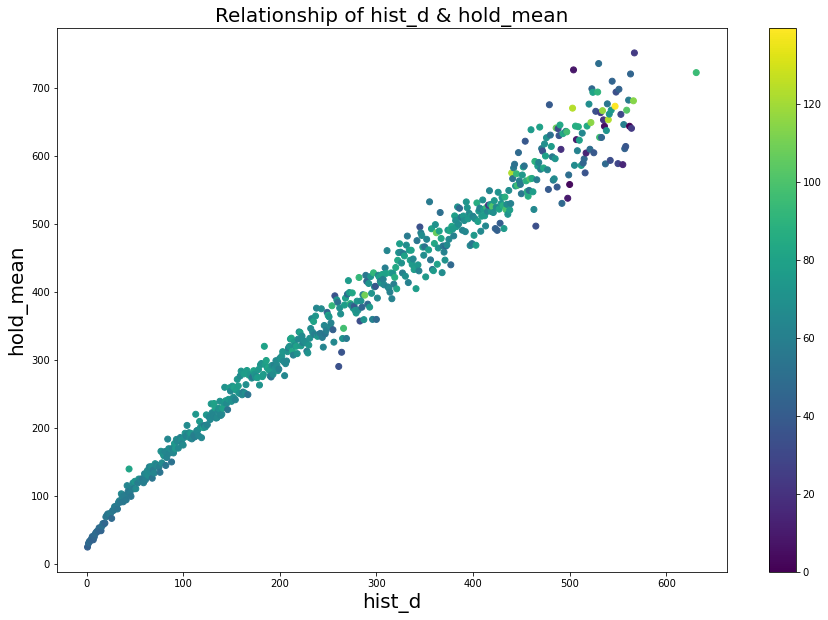

In [31]:
plt.figure(figsize=(15,10))
plt.title("Relationship of hist_d & hold_mean",fontsize=20)
plt.scatter(a['hist'],a['hold_mean'],c=a['after_std'])
plt.xlabel("hist_d",fontsize=20)
plt.ylabel("hold_mean",fontsize=20)
plt.colorbar()
plt.show()

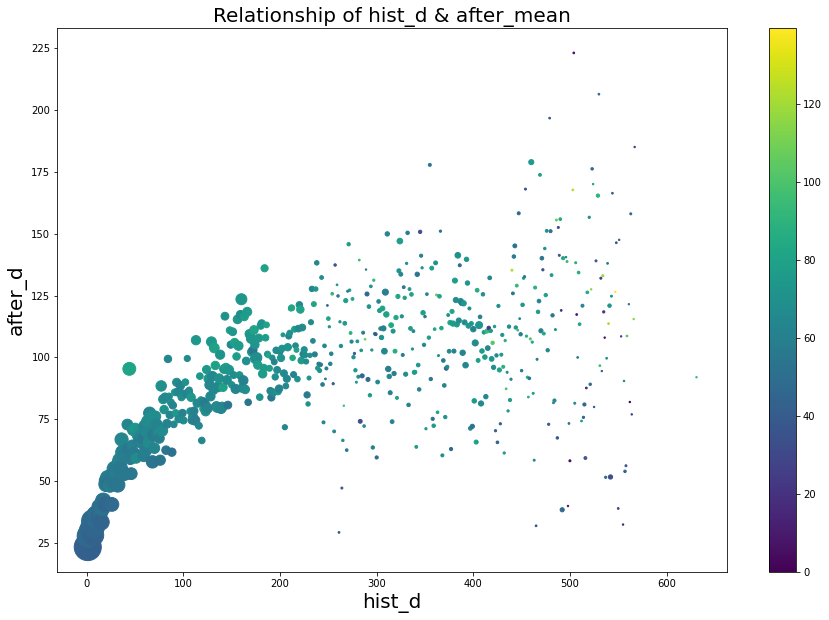

In [32]:
plt.figure(figsize=(15,10))
plt.title("Relationship of hist_d & after_mean",fontsize=20)
plt.scatter(a['hist'],a['after_mean'],s=a['count'],c=a['after_std'])
plt.xlabel("hist_d",fontsize=20)
plt.ylabel("after_d",fontsize=20)
plt.colorbar()
plt.show()

- hist_d에 따른 hold_d 의 평균 그래프를 보니 확실한 직선관계가 보인다. 
- hist_d에 따른 after_d의 평균 그래프를 보니 직선보다는 증가하는 곡선의 trend가 보인다.
- hist_d에 따른 after_d의 표준편차를 보니 hist_d가 작을 때 주로 표준편차가 크며, 이는 예측하기가 어렵다는 것을 말해준다.



### 위의 EDA를 기반으로 (hist_d)^1/2인 sqrt_hist변수를 추가해서, hist_d와 after_d의 곡선 관계를 잡아주고자한다.


In [33]:
new_train['sqrt_hist']=new_train['hist_d']**0.5

# 3. 1차 분석 및 전처리
### 회귀분석을 이용하여 1차 분석을 해보고 그 결과를 바탕으로 다시 전처리를 한다.
### 회귀 분석을 사용한 이유는 다음과 같다
- 여전히 train과 test의 성질이 동일하다고 생각하지 않아, 비교적 과적합의 성향이 약한 회귀분석을 사용하였다.
-  hist_d와 hold_d 사이의 강한 선형성이 보인다.
- 해석이 비교적 용이하다.

### 회귀 시작 전 상관관계를 살펴본다

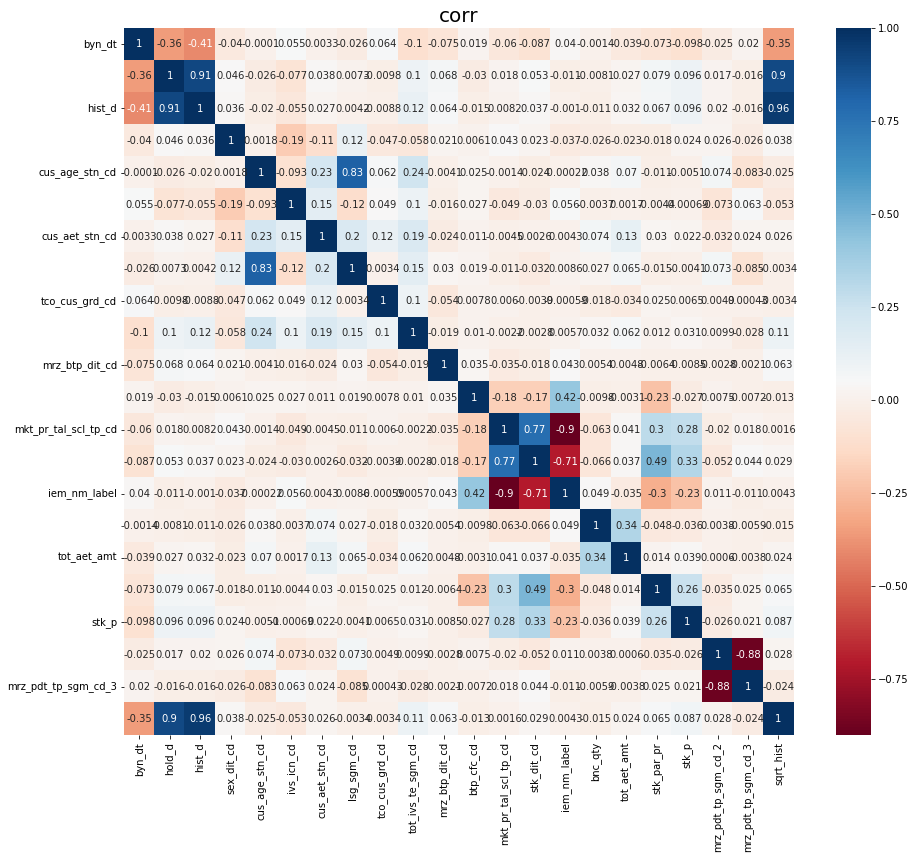

In [34]:
sns.heatmap(data=new_train.corr(),annot=True,cmap='RdBu')
fig=plt.gcf()
fig.set_size_inches(15,13)
plt.title('corr',fontsize=20)
plt.show()

# R을 사용해서 회귀분석을 실시하였습니다. rpy2의 기능을 활용하여 해당 ipynb 내에서 R 코드가 실행되도록 하였으나, 소요시간이 너무 길어 결과를 Markdown으로 삽입하였습니다.







In [35]:
train_R_1=new_train.drop(['act_id', 'iem_cd', 'byn_dt'],axis=1)

In [36]:
# 해당 코드를 돌리면 ipynb 내에서 R코드가 실행됩니다. 시간 관계상 결과를 Image로 제시하였습니다.
'''
%%R -i train_R_1

library(dplyr)
library(forecast)

m=lm(hold_d~.,train_R_1)
summary(m)
checkresiduals(m)
'''

'\n%%R -i train_R_1\n\nlibrary(dplyr)\nlibrary(forecast)\n\nm=lm(hold_d~.,train_R_1)\nsummary(m)\ncheckresiduals(m)\n'

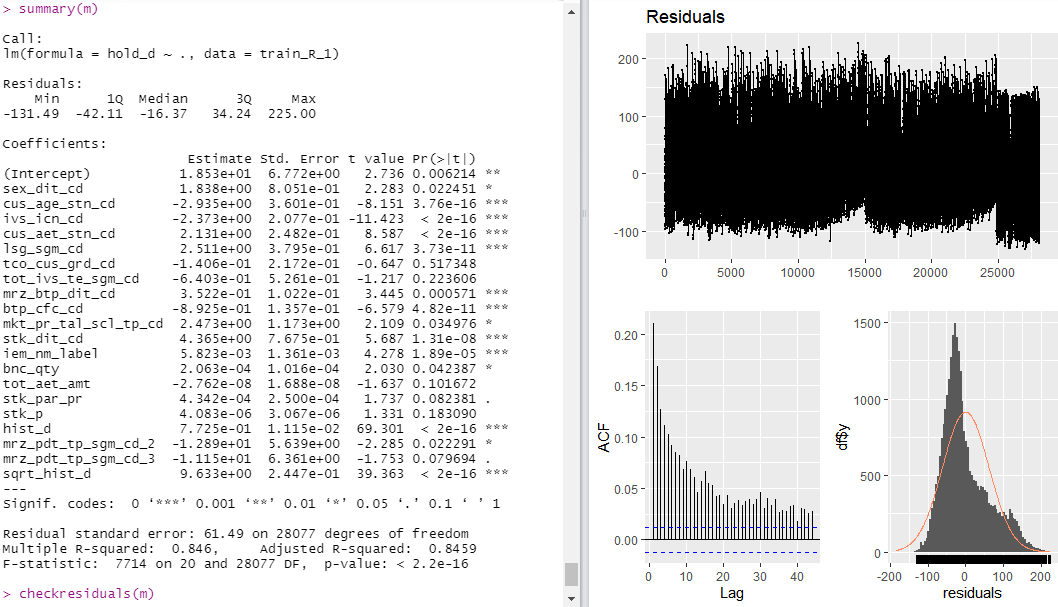

In [37]:
Image("/content/drive/MyDrive/dacon_NH/r2.PNG")

### 분석 결과를 바탕으로 변수별 세부 EDA를 진행하였고 EDA를 기반으로 다음과 같은 전처리를 진행하였다.
- tco_cus_grd_cd 변수를 제거하였다.
- mrz_btp_dit_cd 변수를 제거하였다.
- tot_ivs_te_sgm_cd(총 투자기간) 변수는 6개월 미만에 해당하는 1범주만 두고 나머지는 0으로 바꾸었다.
- stk_dit_cd(시장구분)변수는 코스피, 코스닥만 dummy variable로 넣었다.


### tco_cus_grd_cd, mrz_btp_dit_cd EDA

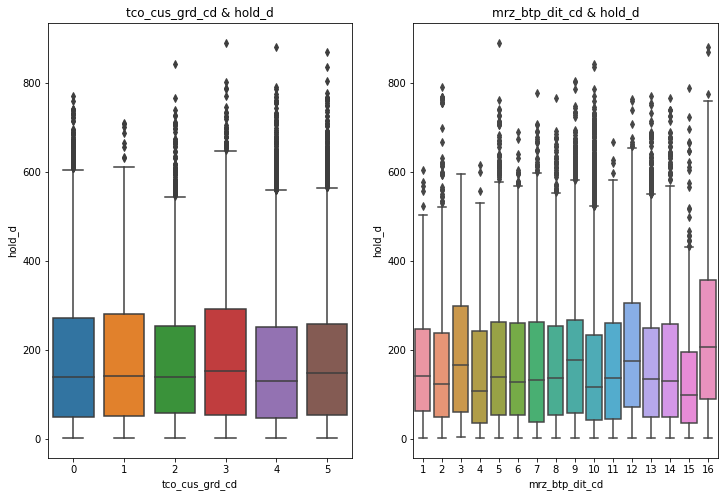

In [38]:
data= new_train

plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
plt.title("tco_cus_grd_cd & hold_d")
sns.boxplot(x="tco_cus_grd_cd",y="hold_d",data=data)

plt.subplot(1,2,2)
plt.title("mrz_btp_dit_cd & hold_d")
sns.boxplot(x="mrz_btp_dit_cd",y="hold_d",data=data)

회귀의 잔차가 normal분포를 따르지 않기에 유의성 기준이 되는 p-value를 그대로 믿을 수 없지만, 그럼에도 두변수는 너무 유의성이 낮았다. 또한 EDA 결과 큰 영향을 주지 못한다고 판단하여 제거하였다

### tot_ivs_te_sgm_cd(총투자기간) EDA

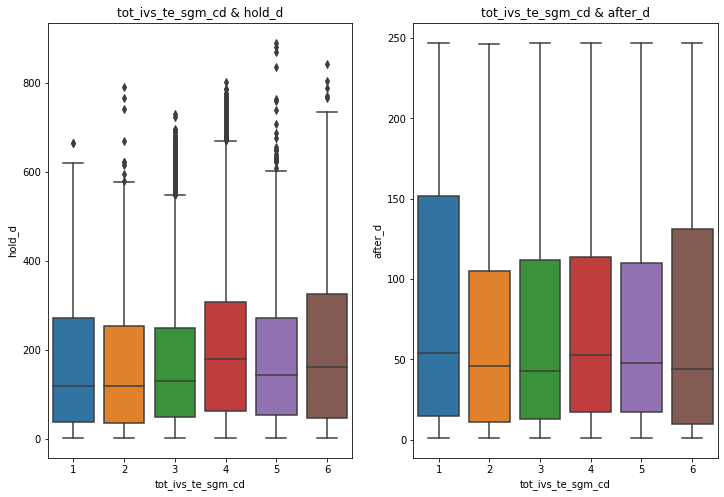

In [41]:
data['after_d']=data['hold_d']-data['hist_d']
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
plt.title("tot_ivs_te_sgm_cd & hold_d")
sns.boxplot(x="tot_ivs_te_sgm_cd",y="hold_d",data=data)

plt.subplot(1,2,2)
plt.title("tot_ivs_te_sgm_cd & after_d")
sns.boxplot(x="tot_ivs_te_sgm_cd",y="after_d",data=data)

tot_ivs_te_sgm_cd 변수 역시 유의성이 좋지 못했다. 하지만 EDA를 실행해보니, 6개월 미만인 경우에 after_d 에서 유의미한 차이를 보인다고 느꼈고, 6개월 미만만 나타내는 변수로 전환하여 추가하였다.

### stk_dit_cd(시장구분) EDA

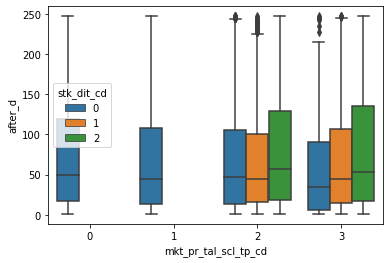

In [42]:
sns.boxplot(x="mkt_pr_tal_scl_tp_cd", y="after_d",
            hue="stk_dit_cd", data=data)

모든 자산 구간에서 1(코스닥),2(코스피)의 plot은 일정한 반면 0의 plot은 그러하지 않다고 판단했다. 이에 1,2 를 나타내는 dummy varuable을 생성하였다.

### 전처리 코드

In [43]:
data=new_train
#  변수 drop
data=data.drop(['tco_cus_grd_cd','mrz_btp_dit_cd'],axis=1)

# 투자기간 6개월 이하인지만 구분
data['tot_ivs_te_sgm_cd']=(data['tot_ivs_te_sgm_cd']==1).astype(int)

# 시장구분 더미화(stk_dit_cd)
data['stk_1']=(data['stk_dit_cd']==1).astype(int)
data['stk_2']=(data['stk_dit_cd']==2).astype(int)
data=data.drop(['stk_dit_cd'],axis=1) ## 기존 변수 drop

# btp_cfc_cd (종목업종) 더미화


new_train=data

# 4. 자기상관성을 제거하기 위한 모델 수정
위의 잔차 그래프에서 자기 상관성의 문제를 발견하였다.



## 우선 자기상관성의 문제를 해결하기로 하였으며, 원인을 다음과 같이 파악하였다.
- 데이터가 train_1920, train_1819, train_1820, train_1720 순서로 **시간적** 그룹 순으로 나열되어있음
- 데이터가 같이 act_id끼리 뭉쳐져있음

### 자기상관성 해결책
 1. act_id로 발생하는 trend를 제거하기 위해서 act_id의 효과를 나타낼 수 있는 변수를 추가한다.
 2. 데이터 shuffle을 통해서 시간적 순서를 제거하고, 독립적인 데이터로 고려하고 분석을 실시한다.


### act_id의 효과를 잡기 위해 추가한 변수는 다음과 같다
- cus_label : act_id가 나열된 순서에 따라서도 성향이 있음을 발견하여 추가

- count : train_all(기존 train)에서 얼마나 많이 구매했는지를 나타내는 변수를 추가

- 1_ratio_round : 구매 횟수 중에 hold_d=1의 비율을 반올림해서 변수로 추가

- hist_mean_id & hist_std_id : id별 hist_d의 평균과 표준편차가 hold_d와 상관성을 보여 추가

### 변수별 EDA

### cus_label

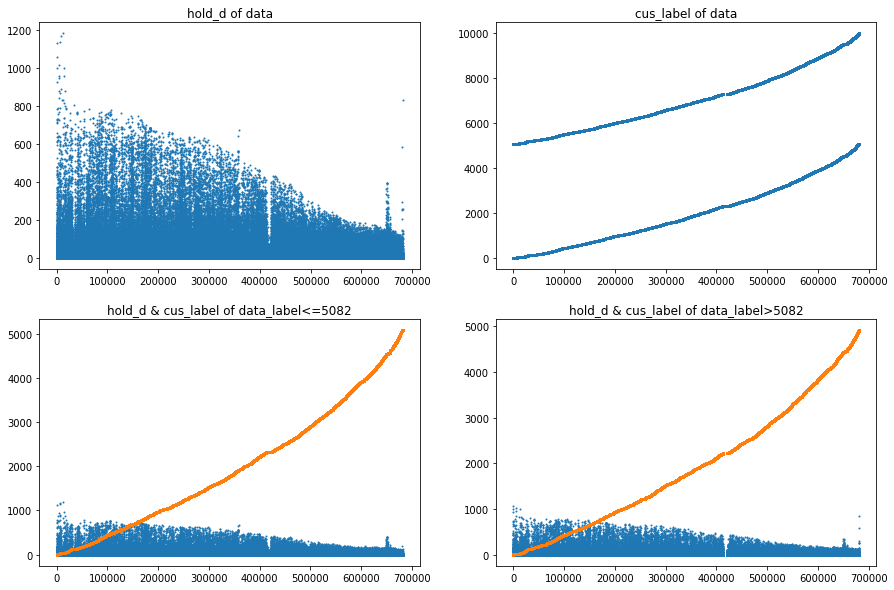

In [45]:
# cus_label
cus['cus_label']=list(range(1,10001))
cus_label=cus[['act_id','cus_label']]

t_cus_label=pd.merge(train_all,cus_label,how="left",on=['act_id'])

t_c_1=t_cus_label[t_cus_label['cus_label']<=5082]
t_c_2=t_cus_label[t_cus_label['cus_label']>5082]
t_c_2['cus_label']=t_c_2['cus_label']-5082

plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.title("hold_d of data")
plt.scatter(t_cus_label.index,t_cus_label.hold_d,s=1)

plt.subplot(2,2,2)
plt.title("cus_label of data")
plt.scatter(t_cus_label.index,t_cus_label.cus_label,s=1)

plt.subplot(2,2,3)
plt.title("hold_d & cus_label of data_label<=5082")
plt.scatter(t_c_1.index,t_c_1.hold_d,s=1)
plt.scatter(t_c_1.index,t_c_1.cus_label,s=1)

plt.subplot(2,2,4)
plt.title("hold_d & cus_label of data_label>5082")
plt.scatter(t_c_2.index,t_c_2.hold_d,s=1)
plt.scatter(t_c_2.index,t_c_2.cus_label,s=1)


### act_id를 cus_info 데이터 순서대로 나열해서 label을 매겼더니 5082를 기준으로 그 이전 label과 그 이후 label 각각이 hold_d 와 반비례하는 성향을 보였다. 

이를 기반으로 5082 이전에 해당하는 label을 cus_label_1, 이후를 cus_label_2로 해서 변수로 사용한다 

In [46]:
new_train_id=pd.merge(new_train,cus_label,how="left",on=['act_id'])

# cus_label_1,2 나누기
new_train_id['cus_label_1']=(new_train_id['cus_label']<=5082).astype(int)
new_train_id['cus_label_2']=(new_train_id['cus_label']>5082).astype(int)

new_train_id['cus_label_1']=new_train_id['cus_label_1']*new_train_id['cus_label']
new_train_id['cus_label_2']=new_train_id['cus_label_2']*new_train_id['cus_label']

# 기존 cus_label제거
new_train_id=new_train_id.drop(['cus_label'],axis=1)

### count 

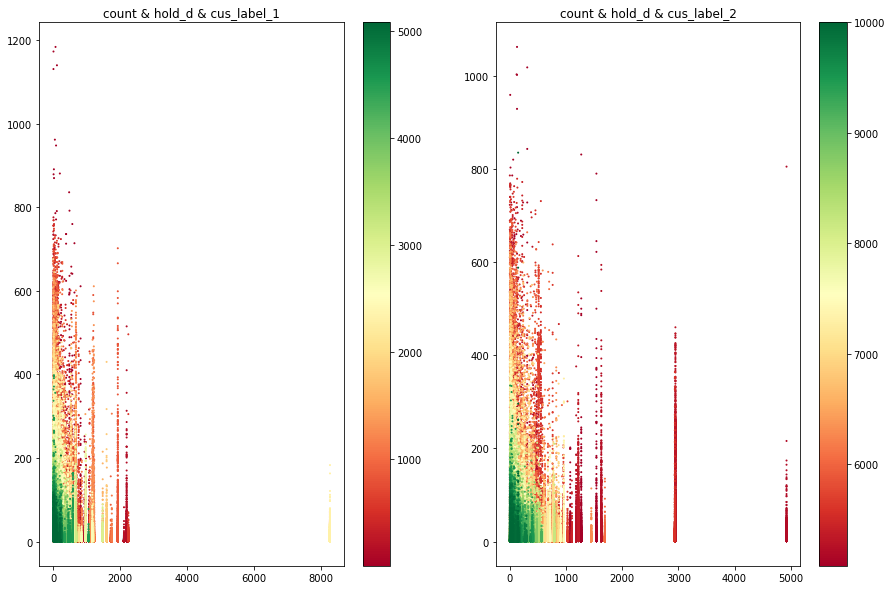

In [47]:
# count 
id_count=pd.DataFrame(train_all['act_id'].value_counts())
id_count['count']=id_count['act_id']
id_count['act_id']=id_count.index
id_count.reset_index(drop=True, inplace=True)

t_id_count=pd.merge(t_cus_label,id_count,how="left",on=['act_id'])

t_id_count_1=t_id_count[t_id_count['cus_label']<5082]
t_id_count_2=t_id_count[t_id_count['cus_label']>5082]

plt.figure(figsize=(15,10))

plt.subplot(1,2,1)
plt.title("count & hold_d & cus_label_1")
plt.scatter(t_id_count_1['count'],t_id_count_1['hold_d'],c=t_id_count_1['cus_label'],s=1,cmap=plt.cm.RdYlGn)
plt.colorbar()

plt.subplot(1,2,2)
plt.title("count & hold_d & cus_label_2")
plt.scatter(t_id_count_2['count'],t_id_count_2['hold_d'],c=t_id_count_2['cus_label'],s=1,cmap=plt.cm.RdYlGn)
plt.colorbar()

### 앞서 조사한 cus_label을 5082 기준으로 나눠서 보니 count와 cus_label을 함께 hold_d d와 EDA해보니 큰 연관성을 찾아볼 수 있다.

그러므로 count역시 변수로 추가한다.



In [48]:
new_train_id=pd.merge(new_train_id,id_count,how="left",on=['act_id'])
new_train_id

,act_id,iem_cd,byn_dt,hold_d,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,lsg_sgm_cd,tot_ivs_te_sgm_cd,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,iem_nm_label,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,mrz_pdt_tp_sgm_cd_2,mrz_pdt_tp_sgm_cd_3,sqrt_hist,after_d,stk_1,stk_2,cus_label_1,cus_label_2,count
0,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,A128820,20190424,174,170,0,4,5,5,3,0,7,1,1099,1670.0,9769500.0,5000.0,5850.0,1,0,13.038405,4,0,0,0,5085,49
1,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,A043200,20190924,71,67,0,4,5,5,3,0,13,1,2098,7999.0,19517560.0,500.0,2440.0,1,0,8.185353,4,0,0,0,5085,49
2,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,A042510,20190524,241,150,0,6,4,4,5,0,13,1,1931,1100.0,3789500.0,500.0,3445.0,1,0,12.247449,91,0,0,2,0,63
3,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,A001045,20190617,164,135,0,6,4,4,5,0,2,0,2311,23.0,1271900.0,5000.0,55300.0,1,0,11.618950,29,0,0,2,0,63
4,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,A166090,20191030,85,43,0,6,4,4,5,0,13,2,349,200.0,3400000.0,500.0,17000.0,1,0,6.557439,42,1,0,2,0,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28093,2eb56d3a0320884e6c50485d323ac58e60a221f3651d8d...,A131370,20171218,545,498,1,5,2,2,5,0,13,2,356,140.0,481600.0,100.0,3440.0,1,0,22.315914,47,1,0,0,5781,28
28094,8dda8cd0b9c8d9689cfe669752f77b412bded98f223325...,A232140,20171212,637,502,1,4,3,1,4,0,13,2,653,288.0,2041920.0,100.0,7090.0,1,0,22.405357,135,0,0,753,0,5
28095,dffcb7aef4c84bba702d63fd63227900a5a018a8fa1b89...,A000660,20171219,729,497,1,6,0,1,6,0,9,3,74,10.0,802000.0,5000.0,80200.0,1,0,22.293497,232,0,1,0,5803,4
28096,c42d66a0c69e8fe964051f1bfb272c5afafacb8dc72b8a...,A068270,20171220,679,496,0,3,3,2,3,0,8,3,62,10.0,2010000.0,1000.0,201000.0,1,0,22.271057,183,0,1,764,0,30


### 1_ratio_round
전체 중에서 hold_d=1의 비율을 EDA 해보니 hold_d 뿐만 아니라 after_d에도 상당한 영향을 주는 것을 볼 수 있었다.

In [49]:
# 1_ratio 생성
train_only_1=train_all[train_all['hold_d']==1]

# 1을 count하는 데이터 생성
train_1_count=pd.DataFrame(train_only_1['act_id'].value_counts())
train_1_count['count_1']=train_1_count['act_id']
train_1_count['act_id']=train_1_count.index
train_1_count.reset_index(drop=True, inplace=True)


# count 데이터와 결합해서 비율 계산
ratio_1=pd.merge(id_count,train_1_count,how="left",on=['act_id'])
ratio_1=ratio_1.fillna(0)  # 값이 존재하지 않으면 hold_d=1이 없다는 것 =>0
ratio_1['1_ratio_round']=round(ratio_1['count_1']/ratio_1['count'],1)

ratio_1_1=ratio_1[['act_id','1_ratio_round']]
# after_d와 의 관계도 보기 위해서 new_train_id 과 결합
new_train_id=pd.merge(new_train_id,ratio_1_1,how="left",on=['act_id'])

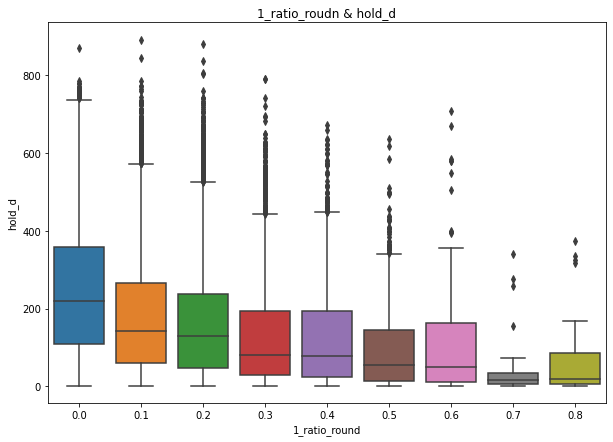

In [50]:
t_id=new_train_id.copy()
t_id['after_d']=t_id['hold_d']-t_id['hist_d']

plt.figure(figsize=(10,7))
plt.title("1_ratio_roudn & hold_d")
sns.boxplot(x="1_ratio_round", y="hold_d", data=t_id)
plt.show()


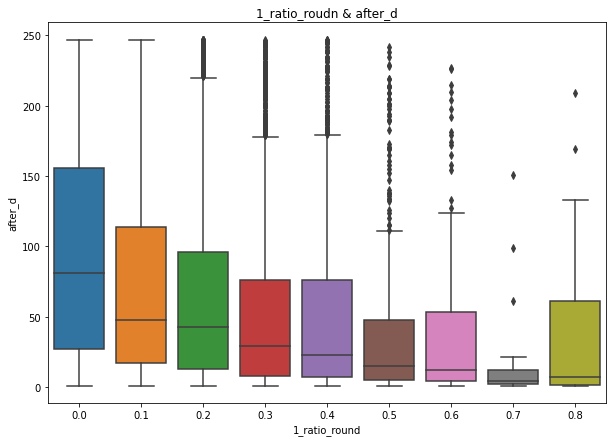

In [51]:
plt.figure(figsize=(10,7))
plt.title("1_ratio_roudn & after_d")
sns.boxplot(x="1_ratio_round", y="after_d", data=t_id)
plt.show()

#### 1_ratio_round가 hold_d 뿐만 아니라 after_d와도 trend를 보인다. 일정한 패턴을 보인다고 판단하여 수치형으로 대입하였다.

### id별 hist_d의 mean & std

hist_d의 std를 구해야하므로 id가 하나 뿐인 경우의 데이터를 제거한다



In [52]:
ii=pd.DataFrame(new_train_id['act_id'].value_counts())
ii['count_ii']=ii['act_id']
ii['act_id']=ii.index
ii.reset_index(drop=True, inplace=True)

no_1=pd.merge(new_train_id,ii,how="left",on=["act_id"])
no_1=no_1[no_1['count_ii']>1]

In [53]:
no_1

,act_id,iem_cd,byn_dt,hold_d,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,lsg_sgm_cd,tot_ivs_te_sgm_cd,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,iem_nm_label,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,mrz_pdt_tp_sgm_cd_2,mrz_pdt_tp_sgm_cd_3,sqrt_hist,after_d,stk_1,stk_2,cus_label_1,cus_label_2,count,1_ratio_round,count_ii
0,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,A128820,20190424,174,170,0,4,5,5,3,0,7,1,1099,1670.0,9769500.0,5000.0,5850.0,1,0,13.038405,4,0,0,0,5085,49,0.1,5
1,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,A043200,20190924,71,67,0,4,5,5,3,0,13,1,2098,7999.0,19517560.0,500.0,2440.0,1,0,8.185353,4,0,0,0,5085,49,0.1,5
2,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,A042510,20190524,241,150,0,6,4,4,5,0,13,1,1931,1100.0,3789500.0,500.0,3445.0,1,0,12.247449,91,0,0,2,0,63,0.1,4
3,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,A001045,20190617,164,135,0,6,4,4,5,0,2,0,2311,23.0,1271900.0,5000.0,55300.0,1,0,11.618950,29,0,0,2,0,63,0.1,4
4,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,A166090,20191030,85,43,0,6,4,4,5,0,13,2,349,200.0,3400000.0,500.0,17000.0,1,0,6.557439,42,1,0,2,0,63,0.1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28092,9176547ed6a48b12ed54ddb20d4be7b0fe35a4d8c1e423...,A000660,20171201,516,509,1,7,0,6,5,0,9,3,74,200.0,15480000.0,5000.0,77400.0,1,0,22.561028,7,0,1,729,0,15,0.0,5
28093,2eb56d3a0320884e6c50485d323ac58e60a221f3651d8d...,A131370,20171218,545,498,1,5,2,2,5,0,13,2,356,140.0,481600.0,100.0,3440.0,1,0,22.315914,47,1,0,0,5781,28,0.0,2
28094,8dda8cd0b9c8d9689cfe669752f77b412bded98f223325...,A232140,20171212,637,502,1,4,3,1,4,0,13,2,653,288.0,2041920.0,100.0,7090.0,1,0,22.405357,135,0,0,753,0,5,0.0,2
28096,c42d66a0c69e8fe964051f1bfb272c5afafacb8dc72b8a...,A068270,20171220,679,496,0,3,3,2,3,0,8,3,62,10.0,2010000.0,1000.0,201000.0,1,0,22.271057,183,0,1,764,0,30,0.1,3


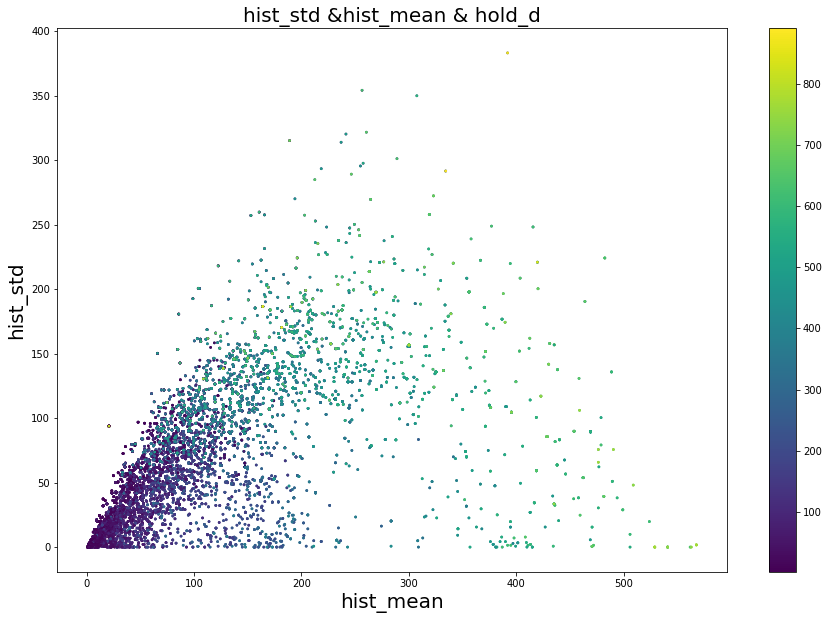

In [54]:
# new_train_id 에서id별로 hist_mean, hist_std 계산
def func(x):
    d={}
    d['hist_mean']=x['hist_d'].mean()
    d['hist_std']=x['hist_d'].std()
 
    return pd.Series(d,index=['hist_mean','hist_std'])

t_id=no_1.groupby(['act_id']).apply(func)
t_id['act_id']=t_id.index
t_id.reset_index(drop=True, inplace=True)
t_id=t_id.fillna(0)

# 데이터 결합
no_1=pd.merge(no_1,t_id,how="left",on=['act_id'])

# 분포 보기
plt.figure(figsize=(15,10))
plt.title("hist_std &hist_mean & hold_d",fontsize=20)
plt.scatter(no_1['hist_mean'],no_1['hist_std'],c=no_1['hold_d'],s=3)
plt.xlabel("hist_mean",fontsize=20)
plt.ylabel("hist_std",fontsize=20)
plt.colorbar()
plt.show()

### hist_mean과 단순히 1차적인 관계라기 보다는 hist_std와 hist_mean에 의한 2차 관계가 hold_d와 더 연관성 있어서 보인다

In [92]:
train_final=no_1
train_final

,act_id,iem_cd,byn_dt,hold_d,hist_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,lsg_sgm_cd,tot_ivs_te_sgm_cd,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,iem_nm_label,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,mrz_pdt_tp_sgm_cd_2,mrz_pdt_tp_sgm_cd_3,sqrt_hist,after_d,stk_1,stk_2,cus_label_1,cus_label_2,count,1_ratio_round,count_ii,hist_mean,hist_std
0,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,A128820,20190424,174,170,0,4,5,5,3,0,7,1,1099,1670.0,9769500.0,5000.0,5850.0,1,0,13.038405,4,0,0,0,5085,49,0.1,5,107.200000,65.583535
1,356b35c423a191e1f5b8cc1dfa2d597c614ba00b52ccae...,A043200,20190924,71,67,0,4,5,5,3,0,13,1,2098,7999.0,19517560.0,500.0,2440.0,1,0,8.185353,4,0,0,0,5085,49,0.1,5,107.200000,65.583535
2,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,A042510,20190524,241,150,0,6,4,4,5,0,13,1,1931,1100.0,3789500.0,500.0,3445.0,1,0,12.247449,91,0,0,2,0,63,0.1,4,90.250000,60.780342
3,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,A001045,20190617,164,135,0,6,4,4,5,0,2,0,2311,23.0,1271900.0,5000.0,55300.0,1,0,11.618950,29,0,0,2,0,63,0.1,4,90.250000,60.780342
4,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,A166090,20191030,85,43,0,6,4,4,5,0,13,2,349,200.0,3400000.0,500.0,17000.0,1,0,6.557439,42,1,0,2,0,63,0.1,4,90.250000,60.780342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26975,9176547ed6a48b12ed54ddb20d4be7b0fe35a4d8c1e423...,A000660,20171201,516,509,1,7,0,6,5,0,9,3,74,200.0,15480000.0,5000.0,77400.0,1,0,22.561028,7,0,1,729,0,15,0.0,5,435.400000,156.865548
26976,2eb56d3a0320884e6c50485d323ac58e60a221f3651d8d...,A131370,20171218,545,498,1,5,2,2,5,0,13,2,356,140.0,481600.0,100.0,3440.0,1,0,22.315914,47,1,0,0,5781,28,0.0,2,476.500000,30.405592
26977,8dda8cd0b9c8d9689cfe669752f77b412bded98f223325...,A232140,20171212,637,502,1,4,3,1,4,0,13,2,653,288.0,2041920.0,100.0,7090.0,1,0,22.405357,135,0,0,753,0,5,0.0,2,289.000000,301.227489
26978,c42d66a0c69e8fe964051f1bfb272c5afafacb8dc72b8a...,A068270,20171220,679,496,0,3,3,2,3,0,8,3,62,10.0,2010000.0,1000.0,201000.0,1,0,22.271057,183,0,1,764,0,30,0.1,3,323.000000,272.402276


### shuffle 하여 시간적 관계성도 제거했다.


In [94]:
train_final=train_final.sample(frac=1).reset_index(drop=True)


### 최종 분석에 사용될 데이터 변수는 다음과 **같다**

In [96]:
train_X_final=train_final.drop(['act_id','iem_cd','byn_dt','hold_d','count_ii','after_d'],axis=1)
train_X_final.columns

Index(['hist_d', 'sex_dit_cd', 'cus_age_stn_cd', 'ivs_icn_cd',
       'cus_aet_stn_cd', 'lsg_sgm_cd', 'tot_ivs_te_sgm_cd', 'btp_cfc_cd',
       'mkt_pr_tal_scl_tp_cd', 'iem_nm_label', 'bnc_qty', 'tot_aet_amt',
       'stk_par_pr', 'stk_p', 'mrz_pdt_tp_sgm_cd_2', 'mrz_pdt_tp_sgm_cd_3',
       'sqrt_hist', 'stk_1', 'stk_2', 'cus_label_1', 'cus_label_2', 'count',
       '1_ratio_round', 'hist_mean', 'hist_std'],
      dtype='object')

# 5. 최종 모델링( GLS를 사용하여 등분산성을 제거하여 준다.)

In [84]:
# 해당 코드를 돌리면 ipynb 내에서 R코드가 실행됩니다. 시간 관계상 결과를 Image로 제시하였습니다.
'''
%%R -i train_R_1

library(car)
library(dplyr)
library(forecast)

m=lm(hold_d~.,train_R_1)
ncvTest(m)

'''

'\n%%R -i train_R_1\n\nlibrary(car)\nlibrary(dplyr)\nlibrary(forecast)\n\nm=lm(hold_d~.,train_R_1)\nncvTest(m)\n\n'

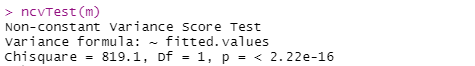

In [85]:
Image("/content/drive/MyDrive/dacon_NH/r3.PNG")

오차가 정규성을 따르지 않아 ncvTest를 사용하여 등분산성을 검정하였고, 등분산성을 만족시키지 않음을 알 수 있었다.

## GLS를 이용하여 등분산성 문제를 해결한다

In [97]:
td_m=train_final.drop(['act_id','iem_cd','byn_dt','hold_d','count_ii','after_d'],axis=1)

## 모델 훈련

In [87]:
# 해당 코드를 돌리면 ipynb 내에서 R코드가 실행됩니다. 

'''
%%R -i td_m

library(nlme)

iter<-glsControl(maxIter=200,tolerance=0.1)

gl<-gls(hold_d~.,data=td_m,weights=varPower(),control=iter)

'''

'\n%%R -i td_m\n\nlibrary(nlme)\n\niter<-glsControl(maxIter=200,tolerance=0.1)\n\ngl<-gls(hold_d~.,data=td_m,weights=varPower(),control=iter)\n\n'

# 6. 예측

## 예측을 위해서 test 전처리


In [98]:
test=pd.read_csv("/content/drive/MyDrive/dacon_NH/stk_hld_test.csv")


In [99]:
# 데이터 결합
cus=pd.read_csv("/content/drive/MyDrive/dacon_NH/cus_info.csv")
iem=pd.read_csv("/content/drive/MyDrive/dacon_NH/iem_info_20210902.csv")
hist=pd.read_csv("/content/drive/MyDrive/dacon_NH/stk_bnc_hist.csv")

hist['stk_p']=hist['tot_aet_amt']/hist['bnc_qty'] # 잔고 하나당 금액
hist=hist.fillna(0)

iem_sort=iem.sort_values(by=['mkt_pr_tal_scl_tp_cd','stk_dit_cd','btp_cfc_cd'],ascending=[True,True,True])
iem_sort['iem_nm_label']=list(range(1,3080))
iem_sort[:5]



test = pd.merge(test,cus,how="left",on=['act_id'])
test = pd.merge(test,iem_sort,how="left",on=["iem_cd"])

test = pd.merge(test, hist, how = "left", on = ["act_id", "iem_cd"])
test = test[(test["byn_dt"] == test["bse_dt"])]
test = test.drop(['bse_dt'],axis=1)
test.reset_index(drop = True, inplace = True)

In [100]:
# 전처리
data=test.copy()

##############################################################3###################################3######
#########################   cus   #######################################################################


# 성별 0,1로
data['sex_dit_cd']=data['sex_dit_cd']-1


# 투자성향(ivs_icn_cd)
#  99는 0으로, 나머지는 그냥 label 유지
ivs_icn_cd_na=(data['ivs_icn_cd']==99).astype(int)        #99인 경우만 1으로 -> 1-na해서 곱해주면 99가 0된다
data['ivs_icn_cd']=data['ivs_icn_cd']*(1-ivs_icn_cd_na)


# 고객 등급 
# 9(등급 미정의)와 99(결측치)는 굳이 영향을 고려하지 않는것이 좋다고 판단된다 => 0으로 변환해준다 
# 나머지는 서열 순으로 되어있으므로 그대로둔다
tco_na=(data['tco_cus_grd_cd']>=9).astype(int)
data['tco_cus_grd_cd']=data['tco_cus_grd_cd']*(1-tco_na)


# 주거래 상품(mrz_pdt_tp_sgm_cd)
# 주로 국내주식 과 해외주식이다. => 국내주식과 해외주식을 나타내는 dummy를 만들고 OW는 00처리한다
data['mrz_pdt_tp_sgm_cd_2']=(data['mrz_pdt_tp_sgm_cd']==2).astype(int) # 국내주식 dummy
data['mrz_pdt_tp_sgm_cd_3']=(data['mrz_pdt_tp_sgm_cd']==3).astype(int) # 국외주식 dummy

data=data.drop(['mrz_pdt_tp_sgm_cd'],axis=1)  # dummy화 했으므로 기존의 변수는 제거한다


# LIFE STAGE, 주거래 업종(mrz_btp)는 그대로 둔다


##############################################################3###################################3######
#########################   iem   #######################################################################


# 시가 총액 
# 규모에 맞게 소,중,대 를(1,2,3)으로 labeling해준다, 또한 99(결측)을 제거한다
# 99를 4로 만들고 4-column 를 하면 위의 순서로 배치된다. 
data['mkt_pr_tal_scl_tp_cd']=data['mkt_pr_tal_scl_tp_cd']-95*(data['mkt_pr_tal_scl_tp_cd']==99).astype(int)
data['mkt_pr_tal_scl_tp_cd']=4-data['mkt_pr_tal_scl_tp_cd']

# 시장구분
# 코스피, 코스닥을 (1,2)로, 기타를 0으로 labeling한다
data['stk_dit_cd']=data['stk_dit_cd']-96*(data['stk_dit_cd']==99).astype(int)
data['stk_dit_cd']=3-data['stk_dit_cd']


# 기업명은 시가총액규모 - 시장구분 - 종목업종 순으로 labeling 되어있으므로 그대로 사용한다
# 종목업종(btp_cfc_cd)역시 서열이 없으므로 그대로 사용한다


##############################################################3###################################3######
#########################   hist   #######################################################################
# hist는 수치적의미 위주이므로 그대로 사용한다

# 기업명 drop
data=data.drop(['iem_krl_nm'],axis=1)

########################################################################################################
# 다시 train으로 복귀
test=data.copy()

In [101]:
test['sqrt_hist']=test['hist_d']**0.5

In [102]:
data=test
#  변수 drop
data=data.drop(['tco_cus_grd_cd','mrz_btp_dit_cd'],axis=1)

# 투자기간 6개월 이하인지만 구분
data['tot_ivs_te_sgm_cd']=(data['tot_ivs_te_sgm_cd']==1).astype(int)

# 시장구분 더미화(stk_dit_cd)
data['stk_1']=(data['stk_dit_cd']==1).astype(int)
data['stk_2']=(data['stk_dit_cd']==2).astype(int)
data=data.drop(['stk_dit_cd'],axis=1) ## 기존 변수 drop

# btp_cfc_cd (종목업종) 더미화


test=data

In [103]:
# cus_label
test=pd.merge(test,cus_label,how="left",on=['act_id'])

# cus_label_1,2 나누기
test['cus_label_1']=(test['cus_label']<=5082).astype(int)
test['cus_label_2']=(test['cus_label']>5082).astype(int)

test['cus_label_1']=test['cus_label_1']*test['cus_label']
test['cus_label_2']=test['cus_label_2']*test['cus_label']

# 기존 cus_label제거
test=test.drop(['cus_label'],axis=1)

In [104]:
# count
test=pd.merge(test,id_count,how="left",on=['act_id'])
test

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,lsg_sgm_cd,tot_ivs_te_sgm_cd,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,iem_nm_label,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,mrz_pdt_tp_sgm_cd_2,mrz_pdt_tp_sgm_cd_3,sqrt_hist,stk_1,stk_2,cus_label_1,cus_label_2,count
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A032640,20200522,153,IDX00001,0,0,9,3,2,9,0,4,3,28,300.0,3945000.0,5000.0,13150.0,1,0,12.369317,0,1,0,5083,94.0
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A160600,20190823,335,IDX00002,0,0,9,3,2,9,0,10,1,1582,198.0,2524500.0,500.0,12750.0,1,0,18.303005,0,0,0,5083,94.0
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A234340,20200611,139,IDX00003,0,0,9,3,2,9,0,13,2,654,138.0,4291800.0,500.0,31100.0,1,0,11.789826,0,0,0,5083,94.0
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A131760,20200120,236,IDX00004,0,0,9,3,2,9,0,13,1,2066,2972.0,6716720.0,500.0,2260.0,1,0,15.362291,0,0,0,5083,94.0
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A293490,20201217,9,IDX00005,0,0,9,3,2,9,0,13,3,169,10.0,464500.0,100.0,46450.0,1,0,3.000000,1,0,0,5083,94.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70591,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A000810,20201127,23,IDX70592,0,0,6,0,5,5,0,2,3,10,1.0,198500.0,500.0,198500.0,1,0,4.795832,0,1,0,10000,149.0
70592,564af3cf975ed4fa05148ada689d5002e9c2d43dee9481...,A005945,20200731,103,IDX70593,0,0,6,0,5,5,0,2,0,2322,50.0,372000.0,5000.0,7440.0,1,0,10.148892,0,0,0,10000,149.0
70593,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A004740,20170704,858,IDX70594,0,0,4,4,2,3,0,14,1,2269,75057.0,3677793.0,100.0,49.0,1,0,29.291637,0,0,5082,0,159.0
70594,4561928f2825f6389f228088ac807a9fb4575ffdcbc47a...,A001630,20201215,11,IDX70595,0,0,4,4,2,3,0,8,2,469,96.0,11424000.0,2500.0,119000.0,1,0,3.316625,0,0,5082,0,159.0


In [105]:
# 1_ratio_round
test=pd.merge(test,ratio_1_1,how="left",on=['act_id'])

In [106]:
# id별 hist_mean , hist_std
def func(x):
    d={}
    d['hist_mean']=x['hist_d'].mean()
    d['hist_std']=x['hist_d'].std()
    return pd.Series(d,index=['hist_mean','hist_std'])

test_id=test.groupby(['act_id']).apply(func)
test_id['act_id']=test_id.index
test_id.reset_index(drop=True, inplace=True)

test_id

################3
# 결합
test=pd.merge(test,test_id,how="left",on=["act_id"])



In [107]:
test[:5]

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,lsg_sgm_cd,tot_ivs_te_sgm_cd,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,iem_nm_label,bnc_qty,tot_aet_amt,stk_par_pr,stk_p,mrz_pdt_tp_sgm_cd_2,mrz_pdt_tp_sgm_cd_3,sqrt_hist,stk_1,stk_2,cus_label_1,cus_label_2,count,1_ratio_round,hist_mean,hist_std
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A032640,20200522,153,IDX00001,0,0,9,3,2,9,0,4,3,28,300.0,3945000.0,5000.0,13150.0,1,0,12.369317,0,1,0,5083,94.0,0.1,174.4,121.094178
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A160600,20190823,335,IDX00002,0,0,9,3,2,9,0,10,1,1582,198.0,2524500.0,500.0,12750.0,1,0,18.303005,0,0,0,5083,94.0,0.1,174.4,121.094178
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A234340,20200611,139,IDX00003,0,0,9,3,2,9,0,13,2,654,138.0,4291800.0,500.0,31100.0,1,0,11.789826,0,0,0,5083,94.0,0.1,174.4,121.094178
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A131760,20200120,236,IDX00004,0,0,9,3,2,9,0,13,1,2066,2972.0,6716720.0,500.0,2260.0,1,0,15.362291,0,0,0,5083,94.0,0.1,174.4,121.094178
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A293490,20201217,9,IDX00005,0,0,9,3,2,9,0,13,3,169,10.0,464500.0,100.0,46450.0,1,0,3.000000,1,0,0,5083,94.0,0.1,174.4,121.094178


In [109]:
test_X=test[train_X_final.columns]
test_d=test_X

# 예측
위에서 생성한 GLS 모델인 gl을 사용하여 예측을 한다.

In [ ]:
# 해당 코드를 돌리면 ipynb 내에서 R코드가 실행됩니다. 

'''
%%R -i test_d

library(nlme)

pred_gls=predict(gl,newdata=test_d)
write.csv(pred_gls,file="gls_predict.csv")
'''

## 예측값 조절
대회 규정상 hist_d+1 <= hold_d =< hist_d+146 이어야한다. 범위를 벗어난 예측값들을 조정해준다

In [ ]:
gls_pred=pd.read_csv("/content/drive/MyDrive/dacon_NH/gls_predict.csv")

In [ ]:
test['hold_d']=gls_pred['x']

# 범위 조정
test['pred']=test['hold_d']
test['min_d']=test['hist_d']+1
test['max_d']=test['hist_d']+146

maxvs=test[['pred','max_d']]
maxvs['pred_max']=maxvs.min(axis=1)

minvs=pd.DataFrame(test['min_d'])
minvs['pred_max']=maxvs['pred_max']
test['pred_final']=minvs.max(axis=1)

# 최종 예측값 추출
ss=test[['submit_id','pred_final']]
ss.rename(columns={"pred_final":"hold_d"},inplace=True)

# 제출 파일 생성
ss.to_csv("sub_1011_03_GLS.csv",index=False)

# Notice
## 모델을 R로 훈련시켰기에 해당 코드를 돌려 결과를 얻기 위해서는 상당히 오랜시간 소요됩니다.
## 그렇기에 예측 결과를 파일로 받아와서 최종 제출 파일 생성까지 코드를 진행하였습니다.
## 이게 문제가 된다면 제일 마지막에 파이썬으로 구현한 회귀 모형을 사용하시면 됩니다.

In [110]:
'''
X=train_X_final
Y=train_final['hold_d']

# 모델 fitting
lr_model = LinearRegression()
model = lr_model.fit(X,Y)

# 모델 훈련
predict=model.predict(test_X)

# 값 조정
test['hold_d']=predict

test['pred']=test['hold_d']
test['min_d']=test['hist_d']+1
test['max_d']=test['hist_d']+146

maxvs=test[['pred','max_d']]
maxvs['pred_max']=maxvs.min(axis=1)

minvs=pd.DataFrame(test['min_d'])
minvs['pred_max']=maxvs['pred_max']
test['pred_final']=minvs.max(axis=1)

# 최종 예측치 추출
ss=test[['submit_id','pred_final']]
ss.rename(columns={"pred_final":"hold_d"},inplace=True)

ss.to_csv("sub_py.csv",index=False)
'''

'\nX=train_X_final\nY=train_final[\'hold_d\']\n\n# 모델 fitting\nlr_model = LinearRegression()\nmodel = lr_model.fit(X,Y)\n\n# 모델 훈련\npredict=model.predict(test_X)\n\n# 값 조정\ntest[\'hold_d\']=predict\n\ntest[\'pred\']=test[\'hold_d\']\ntest[\'min_d\']=test[\'hist_d\']+1\ntest[\'max_d\']=test[\'hist_d\']+146\n\nmaxvs=test[[\'pred\',\'max_d\']]\nmaxvs[\'pred_max\']=maxvs.min(axis=1)\n\nminvs=pd.DataFrame(test[\'min_d\'])\nminvs[\'pred_max\']=maxvs[\'pred_max\']\ntest[\'pred_final\']=minvs.max(axis=1)\n\n# 최종 예측치 추출\nss=test[[\'submit_id\',\'pred_final\']]\nss.rename(columns={"pred_final":"hold_d"},inplace=True)\n\nss.to_csv("sub_py.csv",index=False)\n'